In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [3]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

In [4]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [18]:
optimizer = Adam(0.0002, 0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

In [19]:
def train(epochs, batch_size=128, save_interval=50):
    os.makedirs('fake_images', exist_ok=True)
    
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)

In [20]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("fake_images/mnist_%d.png" % epoch)
    plt.close()

In [21]:
start = time.time()

train(epochs=2000, batch_size=32, save_interval=10)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

0 [D loss: 1.007773, acc.: 34.38%] [G loss: 0.679310]
10 [D loss: 0.495245, acc.: 84.38%] [G loss: 0.888768]
20 [D loss: 0.553829, acc.: 71.88%] [G loss: 1.307590]
30 [D loss: 0.797100, acc.: 56.25%] [G loss: 1.564346]
40 [D loss: 0.842457, acc.: 51.56%] [G loss: 0.977436]
50 [D loss: 0.940994, acc.: 42.19%] [G loss: 0.768322]
60 [D loss: 0.856274, acc.: 48.44%] [G loss: 1.133547]
70 [D loss: 0.855650, acc.: 46.88%] [G loss: 1.286670]
80 [D loss: 0.809316, acc.: 53.12%] [G loss: 1.455677]
90 [D loss: 0.922692, acc.: 48.44%] [G loss: 1.310336]
100 [D loss: 0.905297, acc.: 51.56%] [G loss: 1.101721]
110 [D loss: 0.849784, acc.: 46.88%] [G loss: 1.259891]
120 [D loss: 0.662125, acc.: 60.94%] [G loss: 1.119827]
130 [D loss: 0.566673, acc.: 75.00%] [G loss: 0.952858]
140 [D loss: 0.849430, acc.: 48.44%] [G loss: 1.147094]
150 [D loss: 0.943067, acc.: 37.50%] [G loss: 1.072397]
160 [D loss: 0.880923, acc.: 51.56%] [G loss: 0.951131]
170 [D loss: 0.983025, acc.: 34.38%] [G loss: 1.092214]
180

KeyboardInterrupt: ignored

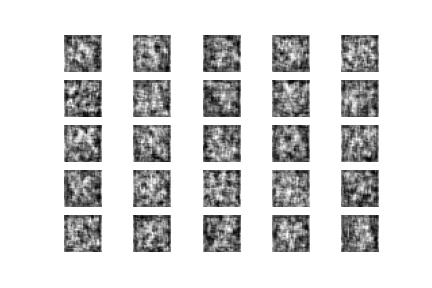

In [22]:
Image.open('fake_images/mnist_10.png')

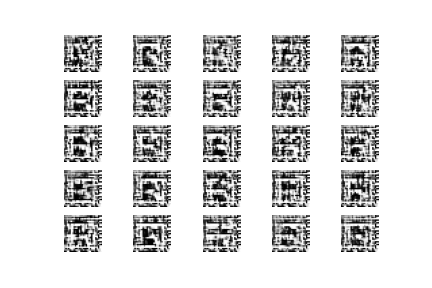

In [34]:
Image.open('fake_images/mnist_1200.png')

In [13]:
start = time.time()

train(epochs=25000, batch_size=32, save_interval=1000)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

0 [D loss: 0.359187, acc.: 87.50%] [G loss: 0.890683]
1000 [D loss: 0.000228, acc.: 100.00%] [G loss: 0.395947]
2000 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.850426]
3000 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.714415]
4000 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.024556]
5000 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.007829]
6000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.023340]
7000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.007121]
8000 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.528606]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.663602]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.193569]


KeyboardInterrupt: ignored

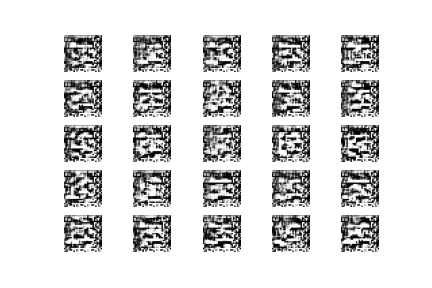

In [17]:
Image.open('fake_images/mnist_1000.png')

In [ ]:
Image.open('fake_images/mnist_25000.png')